In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:34791' processes=9 threads=162, memory=419.10 GiB>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
cfg_var_photoC_TOT_zint_100m=CESM2_config()
cfg_var_photoC_TOT_zint_100m.year_s=1955
cfg_var_photoC_TOT_zint_100m.year_e=2020
cfg_var_photoC_TOT_zint_100m.setvar('photoC_TOT_zint_100m')
# cfg_var_DpCO2.list()

cfg_var_TAUX=CESM2_config()
cfg_var_TAUX.year_s=1955
cfg_var_TAUX.year_e=2020
cfg_var_TAUX.setvar('TAUX')

cfg_var_TAUY=CESM2_config()
cfg_var_TAUY.year_s=1955
cfg_var_TAUY.year_e=2020
cfg_var_TAUY.setvar('TAUY')

cfg_var_NO3=CESM2_config()
cfg_var_NO3.year_s=1955
cfg_var_NO3.year_e=2020
cfg_var_NO3.setvar('NO3')

cfg_var_Fe=CESM2_config()
cfg_var_Fe.year_s=1955
cfg_var_Fe.year_e=2020
cfg_var_Fe.setvar('Fe')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1955
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

cfg_var_SSH=CESM2_config()
cfg_var_SSH.year_s=1955
cfg_var_SSH.year_e=2020
cfg_var_SSH.setvar('SSH')

cfg_var_HBLT=CESM2_config()
cfg_var_HBLT.year_s=1955
cfg_var_HBLT.year_e=2020
cfg_var_HBLT.setvar('HBLT')


if cfg_var_photoC_TOT_zint_100m.comp=='ocn':
    ds_grid = pop_tools.get_grid('POP_gx1v7')



In [5]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

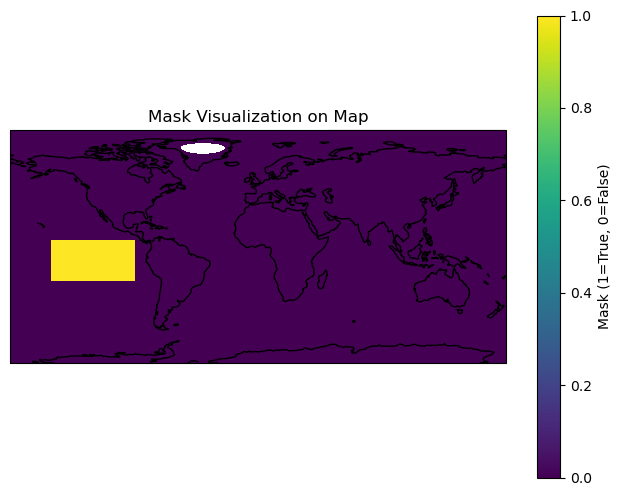

In [6]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [7]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

# data = cfg_var_NO3.LE_ds['NO3']
# weighted_sum = (data * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(data.notnull()).sum(dim=['nlat','nlon'], skipna=True)
# weighted_avg_manual['NO3'] = weighted_sum / effective_area



exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_photoC_TOT_zint_100m.var, 
          cfg_var_TAUX.var, cfg_var_TAUY.var, cfg_var_NO3.var, cfg_var_Fe.var, cfg_var_TEMP.var, cfg_var_SSH.var, cfg_var_HBLT.var]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))

    # area = ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * area).sum(dim=['nlat','nlon'], skipna=True)
    # effective_area = area.where(ds[varname].notnull()).sum(dim=['nlat','nlon'], skipna=True)
    # ds[varname] = weighted_sum / effective_area
    
    volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_photoC_TOT_zint_100m.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_photoC_TOT_zint_100m.year_e+1, 1, 1)

In [8]:
# Read LE dataset

start_time = time.time()

# TEMP
dname=cfg_var_TEMP.var
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)


# photoC_TOT_zint_100m
dname=cfg_var_photoC_TOT_zint_100m.var
cfg_var_photoC_TOT_zint_100m.LE_path_load(cfg_var_photoC_TOT_zint_100m.var)
cfg_var_photoC_TOT_zint_100m.LE_ds = xr.open_mfdataset(cfg_var_photoC_TOT_zint_100m.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_photoC_TOT_zint_100m.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_photoC_TOT_zint_100m.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_TOT_zint_100m.LE_ds.time))
cfg_var_photoC_TOT_zint_100m.LE_ds = cfg_var_photoC_TOT_zint_100m.LE_ds.assign_coords(time=new_time)

# SSH
dname=cfg_var_SSH.var
cfg_var_SSH.LE_path_load(cfg_var_SSH.var)
cfg_var_SSH.LE_ds = xr.open_mfdataset(cfg_var_SSH.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_SSH.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_SSH.LE_ds = cfg_var_SSH.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_SSH.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_SSH.LE_ds.time))
cfg_var_SSH.LE_ds = cfg_var_SSH.LE_ds.assign_coords(time=new_time)



# TAUX
dname=cfg_var_TAUX.var
cfg_var_TAUX.LE_path_load(cfg_var_TAUX.var)
cfg_var_TAUX.LE_ds = xr.open_mfdataset(cfg_var_TAUX.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUX.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TAUX.LE_ds = cfg_var_TAUX.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TAUX.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUX.LE_ds.time))
cfg_var_TAUX.LE_ds = cfg_var_TAUX.LE_ds.assign_coords(time=new_time)

# TAUY
dname=cfg_var_TAUY.var
cfg_var_TAUY.LE_path_load(cfg_var_TAUY.var)
cfg_var_TAUY.LE_ds = xr.open_mfdataset(cfg_var_TAUY.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUY.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TAUY.LE_ds = cfg_var_TAUY.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TAUY.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUY.LE_ds.time))
cfg_var_TAUY.LE_ds = cfg_var_TAUY.LE_ds.assign_coords(time=new_time)


# NO3
dname=cfg_var_NO3.var
cfg_var_NO3.LE_path_load(cfg_var_NO3.var)
cfg_var_NO3.LE_ds = xr.open_mfdataset(cfg_var_NO3.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_NO3.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_NO3.LE_ds = cfg_var_NO3.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_NO3.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_NO3.LE_ds.time))
cfg_var_NO3.LE_ds = cfg_var_NO3.LE_ds.assign_coords(time=new_time)


# Fe
dname=cfg_var_Fe.var
cfg_var_Fe.LE_path_load(cfg_var_Fe.var)
cfg_var_Fe.LE_ds = xr.open_mfdataset(cfg_var_Fe.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_Fe.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_Fe.LE_ds = cfg_var_Fe.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_Fe.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_Fe.LE_ds.time))
cfg_var_Fe.LE_ds = cfg_var_Fe.LE_ds.assign_coords(time=new_time)


# HBLT
dname=cfg_var_HBLT.var
cfg_var_HBLT.LE_path_load(cfg_var_HBLT.var)
cfg_var_HBLT.LE_ds = xr.open_mfdataset(cfg_var_HBLT.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_HBLT.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_HBLT.LE_ds = cfg_var_HBLT.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_HBLT.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_HBLT.LE_ds.time))
cfg_var_HBLT.LE_ds = cfg_var_HBLT.LE_ds.assign_coords(time=new_time)


end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

2025-02-05 17:14:46,545 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {'lambda-ec2bb72e-da09-4330-a8db-5eabd5561d3c': ()}


elasped time for reading LE: 1699.477133989334


In [9]:
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# # 데이터 시각화
# pc = ax.pcolormesh(
#     cfg_var_TEMP.LE_ds['TLONG'], 
#     cfg_var_TEMP.LE_ds['TLAT'], 
#     cfg_var_TEMP.LE_ds['TEMP'].sel(ens_LE=0).isel(time=0).isel(z_t=0),
#     transform=ccrs.PlateCarree(),
#     cmap='viridis'
# )

# ax.coastlines()

# # **여기서부터 축 라벨(경/위도) 표시**
# gl = ax.gridlines(draw_labels=True)  # 경/위도 선 + 라벨 켜기
# gl.top_labels = False                # 위쪽 라벨 끄기
# gl.right_labels = False              # 오른쪽 라벨 끄기

# # (선택) 라벨 스타일(폰트 크기 등) 지정 가능
# gl.xlabel_style = {'size': 10}
# gl.ylabel_style = {'size': 10}

# # 색상바
# cbar = plt.colorbar(pc, ax=ax, label='data')

# # 플롯 제목
# plt.title('Selected dataset')
# plt.show()

In [10]:
cfg_var_SSH.LE_ds

<xarray.Dataset>
Dimensions:  (ens_LE: 50, time: 792, z_w: 60, nlat: 110, nlon: 54)
Coordinates:
  * z_w      (z_w) float32 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(110, 54), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(110, 54), meta=np.ndarray>
  * time     (time) object 1955-01-17 00:00:00 ... 2020-12-17 00:00:00
  * ens_LE   (ens_LE) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: nlat, nlon
Data variables:
    SSH      (ens_LE, time) float64 dask.array<chunksize=(1, 12), meta=np.ndarray>
Attributes:
    title:             b.e21.BHISTsmbb.f09_g17.LE2-1011.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-03-18 at 02:27:56.5
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [13]:
filename

'/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_x1_210_x2_270_y1_-20_y2_10.nc'

In [12]:
start_time = time.time()

comp_dataset=xr.Dataset()
comp_dataset['TEMP']= cfg_var_TEMP.LE_ds['TEMP']
comp_dataset['photoC_TOT_zint_100m']= cfg_var_photoC_TOT_zint_100m.LE_ds['photoC_TOT_zint_100m']
comp_dataset['SSH']= cfg_var_SSH.LE_ds['SSH']
comp_dataset['TAUX']= cfg_var_TAUX.LE_ds['TAUX']
comp_dataset['TAUY']= cfg_var_TAUY.LE_ds['TAUY']
comp_dataset['NO3']= cfg_var_NO3.LE_ds['NO3']
comp_dataset['Fe']= cfg_var_Fe.LE_ds['Fe']
comp_dataset['HBLT']= cfg_var_HBLT.LE_ds['HBLT']


mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))


filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
if os.path.exists(filename):
    os.remove(filename)
comp_dataset.to_netcdf(filename, mode='w')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

elasped time for writing netcdf: 8229.082517623901


In [ ]:
# Read Observation dataset
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})

# new_time = cfg_var_TEMP.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.OBS_ds.time))
# cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.assign_coords(time=new_time)

if cfg_var_TEMP.var=='SSH':
    cfg_var_TEMP.OBS_ds=cfg_var_TEMP.OBS_ds.assign_coords(time=cfg_var_TEMP.LE_ds.time[396:732]) #1993~2020
elif cfg_var_TEMP.var=='photoC_TOT_zint_100m':
    cfg_var_TEMP.OBS_ds=cfg_var_TEMP.OBS_ds.assign_coords(time=cfg_var_TEMP.LE_ds.time[456:732]) #1999~2020
elif cfg_var_TEMP.var=='FG_CO2':
    cfg_var_TEMP.OBS_ds=cfg_var_TEMP.OBS_ds.assign_coords(time=cfg_var_TEMP.LE_ds.time[264:732])

cfg_var_TEMP.OBS_ds.time

# global mean removal for SSH
if cfg_var_TEMP.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_TEMP.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_TEMP.OBS_ds['SSH'] = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var] - cfg_var_TEMP.OBS_ds['gm']


cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_sum = (cfg_var_TEMP.OBS_ds['TEMP'] * area).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area.where(cfg_var_TEMP.OBS_ds['TEMP'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
cfg_var_TEMP.OBS_ds['TEMP'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

In [ ]:
cfg_var_photoC_TOT_zint_100m.OBS_ds

In [ ]:
# Read Observation dataset (NPP)
start_time = time.time()
# photoC_TOT_zint_100m
cfg_var_photoC_TOT_zint_100m.OBS_path_load(cfg_var_photoC_TOT_zint_100m.var)
dname=cfg_var_photoC_TOT_zint_100m.OBS_var
cfg_var_photoC_TOT_zint_100m.OBS_ds = xr.open_mfdataset(
    cfg_var_photoC_TOT_zint_100m.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.rename({cfg_var_photoC_TOT_zint_100m.OBS_var: cfg_var_photoC_TOT_zint_100m.var})

# new_time = cfg_var_photoC_TOT_zint_100m.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_photoC_TOT_zint_100m.OBS_ds.time))
# cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=new_time)

if cfg_var_photoC_TOT_zint_100m.var=='SSH':
    cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[396:732]) #1993~2020
elif cfg_var_photoC_TOT_zint_100m.var=='photoC_TOT_zint_100m':
    cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[456:732]) #1999~2020
elif cfg_var_photoC_TOT_zint_100m.var=='FG_CO2':
    cfg_var_photoC_TOT_zint_100m.OBS_ds=cfg_var_photoC_TOT_zint_100m.OBS_ds.assign_coords(time=cfg_var_photoC_TOT_zint_100m.LE_ds.time[264:732])

cfg_var_photoC_TOT_zint_100m.OBS_ds.time

# global mean removal for SSH
if cfg_var_photoC_TOT_zint_100m.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_photoC_TOT_zint_100m.OBS_ds[cfg_var_photoC_TOT_zint_100m.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_photoC_TOT_zint_100m.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_photoC_TOT_zint_100m.OBS_ds['SSH'] = cfg_var_photoC_TOT_zint_100m.OBS_ds[cfg_var_photoC_TOT_zint_100m.var] - cfg_var_photoC_TOT_zint_100m.OBS_ds['gm']


cfg_var_photoC_TOT_zint_100m.OBS_ds = cfg_var_photoC_TOT_zint_100m.OBS_ds.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_sum = (cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'] * area).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area.where(cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))


In [ ]:
# Read Observation dataset (SSH)
start_time = time.time()

# SSH
cfg_var_SSH.OBS_path_load(cfg_var_SSH.var)
dname=cfg_var_SSH.OBS_var
cfg_var_SSH.OBS_ds = xr.open_mfdataset(
    cfg_var_SSH.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds.rename({cfg_var_SSH.OBS_var: cfg_var_SSH.var})

# new_time = cfg_var_SSH.OBS_ds.time + np.array([datetime.timedelta(days=15)] * len(cfg_var_SSH.OBS_ds.time))
# cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds.assign_coords(time=new_time)

if cfg_var_SSH.var=='SSH':
    cfg_var_SSH.OBS_ds=cfg_var_SSH.OBS_ds.assign_coords(time=cfg_var_SSH.LE_ds.time[396:732]) #1993~2020
elif cfg_var_SSH.var=='photoC_TOT_zint_100m':
    cfg_var_SSH.OBS_ds=cfg_var_SSH.OBS_ds.assign_coords(time=cfg_var_SSH.LE_ds.time[456:732]) #1999~2020
elif cfg_var_SSH.var=='FG_CO2':
    cfg_var_SSH.OBS_ds=cfg_var_SSH.OBS_ds.assign_coords(time=cfg_var_SSH.LE_ds.time[264:732])

cfg_var_SSH.OBS_ds.time

# global mean removal for SSH
if cfg_var_SSH.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_SSH.OBS_ds[cfg_var_SSH.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    # 필터링된 지역에 대해 global mean 계산
    cfg_var_SSH.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
    # 원 데이터에서 global mean을 제거한 값
    cfg_var_SSH.OBS_ds['SSH'] = cfg_var_SSH.OBS_ds[cfg_var_SSH.var] - cfg_var_SSH.OBS_ds['gm']


cfg_var_SSH.OBS_ds = cfg_var_SSH.OBS_ds.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_sum = (cfg_var_SSH.OBS_ds['SSH'] * area).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area.where(cfg_var_SSH.OBS_ds['SSH'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
cfg_var_SSH.OBS_ds['SSH'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

In [ ]:
start_time = time.time()

comp_dataset=xr.Dataset()
comp_dataset['obs_SST']= cfg_var_TEMP.OBS_ds['TEMP']

mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))


filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
if os.path.exists(filename):
    os.remove(filename)
comp_dataset.to_netcdf(filename, mode='w')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

In [ ]:
start_time = time.time()

comp_dataset=xr.Dataset()
comp_dataset['obs_SSH']= cfg_var_SSH.OBS_ds['SSH']

mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))


filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
if os.path.exists(filename):
    os.remove(filename)
comp_dataset.to_netcdf(filename, mode='w')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

In [ ]:
start_time = time.time()

comp_dataset=xr.Dataset()
comp_dataset['obs_photoC_TOT_zint_100m']= cfg_var_photoC_TOT_zint_100m.OBS_ds['photoC_TOT_zint_100m']

mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))


filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
if os.path.exists(filename):
    os.remove(filename)
comp_dataset.to_netcdf(filename, mode='w')

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))